In [ ]:
!pip install opencv-python

In [2]:
from google.colab import drive
from google.colab.patches import cv2_imshow

import os
import cv2
import json

import matplotlib.pyplot as plt
import numpy as np
#from sklearn.model_selection import train_test_split

import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Препроцессинг

Первое что серьезно бросается в глаза пи изучении датасета это наличие наличие лиц на изображении. Дело в том что если не найти отдельный способ выделениея кисти и обучения на ней то при таком мальнком сете для обучения могут возникнуть проблемы детекции label по другим признакам, например: фон, выражение лица, прическа и.т.д. Необходимо выбрать оптимальное решение дял вырезки кистей.

### Каскады

 Каскады от opencv просты и быстры в использовании. Для хорошей детекции необходима правильная настройка. Для использования в деле требуют динамичного поведения на изображении плохо работают для задач со статичными обьектами

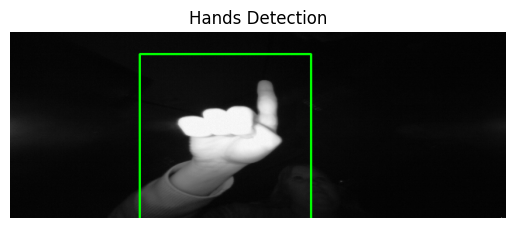

In [ ]:
# Инициализация CascadeClassifier для рук
hand_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/sets/pytorch/haarcascade_hand.xml')

# Загрузка изображения
img = cv2.imread('/content/drive/MyDrive/sets/pytorch/leapGestRecog/02/06_index/frame_02_06_0189.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Обнаружение рук
hands = hand_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=2, minSize=(64, 64))

# Отрисовка прямоугольников вокруг обнаруженных рук
# bias нужен чтобы не было потери краев детектируемого обьекта
x_img_bias = 30
y_img_bias = 20
for (x, y, w, h) in hands:
    cv2.rectangle(img, (x-x_img_bias, y-x_img_bias), (x+w+x_img_bias, y+h+x_img_bias), (0, 255, 0), 2)

# Отображение результата
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Hands Detection')
plt.axis('off')
plt.show()


Еще по желанию можно добавить отрисовку узоров для доплонительной защиты от лишних обьектов. Сдесь это позволяет легко сделать четкое выделение светом ладони на самих изображениях сета.

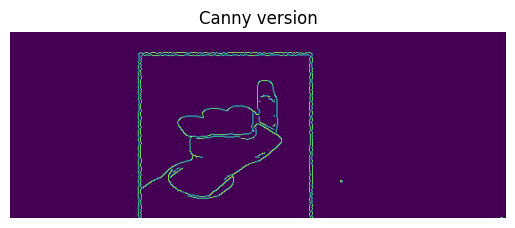

In [ ]:

plt.imshow(cv2.Canny(img, 60, 150))
plt.title('Canny version')
plt.axis('off')
plt.show()

Создание нового сета из ладоней

In [ ]:
path = '/content/drive/MyDrive/sets/pytorch/leapGestRecog'
new_path = '/content/drive/MyDrive/sets/pytorch/leapGestRecog_palms'

amount_img = 0
for palms in os.listdir(path):
  for palms_classes in os.listdir(path+"/"+palms):
    amount_img += len(os.listdir(path+"/"+palms+"/"+palms_classes))

amount_img

20030

In [ ]:
#обрезка изображения
def crop_hand(image, x, y, w, h, x_increase=x_img_bias, y_increase=y_img_bias):
    image_h, image_w = image.shape[:2]

    x_start = max(0, x - x_increase)
    y_start = max(0, y - y_increase)
    x_end = min(image_w, x + w + x_increase)
    y_end = min(image_h, y + h + y_increase)

    cropped_hand = image[y_start:y_end, x_start:x_end]

    return cropped_hand

In [ ]:
images = []
labels = []
сount_detected_plams = 0
number_of_img = 0
for palms in os.listdir(path):
  for palms_classes in os.listdir(path+"/"+palms):
    for name_img in os.listdir(path+"/"+palms+"/"+palms_classes):
      number_of_img+=1

      img = cv2.imread(path+"/"+palms+"/"+palms_classes+"/"+name_img)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      hands = hand_cascade.detectMultiScale(gray, scaleFactor=1.04, minNeighbors=1, minSize=(64, 64))
      if len(hands)>0:
        сount_detected_plams += 1

        max_size = 0
        palm_img = None
        for i in hands:
          x, y, w, h = hands[i]

          #вырезаю кусок изображения, соответствующий руке, намеренно записываю его в трехмерном gray
          hand_roi = crop_hand(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB), x, y, w, h)
          height, width, _ = hand_roi.shape
          if (height+1*width+1)>max_size:
            palm_img = hand_roi

        #сразу делаю ресайз таким образом оптимизируя свой препроцессинг
        palm_img = cv2.resize(palm_img, (64, 64))
        labels.append(palms_classes)

        #cохраняю
        #cv2.imwrite((new_path+"/"+palms+"/"+palms_classes+"/"+name_img), palm_img)
        images.append(palm_img)

      if number_of_img%10==0 and number_of_img<50:
        print(f"{number_of_img}/{amount_img}")
      if number_of_img%200==0 and number_of_img<1000:
        print(f"{number_of_img}/{amount_img}")
      if number_of_img%2000==0:
        print(f"{number_of_img}/{amount_img}")

print(f"Количество изображенний с наиденной рукой {сount_detected_plams}/{amount_img} \| {сount_detected_plams/amount_img}%")


10/20030
20/20030
30/20030
40/20030
200/20030
400/20030
600/20030
800/20030
2000/20030
4000/20030
6000/20030
8000/20030
10000/20030
12000/20030
14000/20030
16000/20030
18000/20030
20000/20030
Количество изображенний с наиденной рукой 14447/20030 \| 0.7212680978532202%


In [ ]:
np.save(new_path + '/' + 'images_array-14447-64-64-3.npy', np.array(images))

In [ ]:
with open(new_path + '/' + 'labels.json', 'w') as json_file:
  json.dump(labels, json_file)

### Прорисовка скелетов - mediapipe

Прорисовка скелета кисти существенно улучшает точность выполнения задачи по обработки информативности значения жеста. Но это будет требовать хорошую производительность железа.

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 29.9 MB/s eta 0:00:00


<ipython-input-15-59f58b923cc2>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x, y, w, h = cv2.boundingRect(np.array(landmarks_list).astype(np.int))


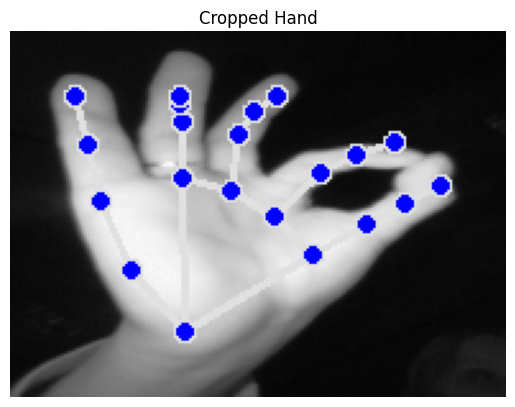

In [ ]:
import mediapipe as mp

x_bias = 25
y_bias = 25

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# Загрузка модели Hands
hands = mp_hands.Hands()

# Загрузка изображения
image = cv2.imread('/content/drive/MyDrive/sets/pytorch/leapGestRecog/02/07_ok/frame_02_07_0001.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
height, width, _ = image.shape

# Обнаружение ключевых точек рук
results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Вывод результатов
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Определение области, содержащей руку
        landmarks_list = [(lm.x * width, lm.y * height) for lm in hand_landmarks.landmark]
        x, y, w, h = cv2.boundingRect(np.array(landmarks_list).astype(np.int))

        # Выделение руки в прямоугольник
        hand_cropped = image[y-x_bias:y+h+x_bias, x-x_bias:x+w+x_bias]

        # Отображение результата
        plt.imshow(hand_cropped)
        plt.title('Cropped Hand')
        plt.axis('off')
        plt.show()

In [ ]:
path = '/content/drive/MyDrive/sets/pytorch/leapGestRecog'
new_path = '/content/drive/MyDrive/sets/pytorch/leapGestRecog_medipipe'

сount_detected_plams = 0
number_of_img = 0
static = []
images = []
labels = []
for palms in os.listdir(path):
  for palms_classes in os.listdir(path+"/"+palms):
    for name_img in os.listdir(path+"/"+palms+"/"+palms_classes):
      number_of_img+=1

      image = cv2.imread(path+"/"+palms+"/"+palms_classes+"/"+name_img)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

      results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_hand_landmarks:
        static.append(f"{palms} - {palms_classes}")
        сount_detected_plams +=1

        for hand_landmarks in results.multi_hand_landmarks:
          mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

          # Определение области, содержащей руку
          landmarks_list = [(lm.x * width, lm.y * height) for lm in hand_landmarks.landmark]
          x, y, w, h = cv2.boundingRect(np.array(landmarks_list).astype(np.int))

          # Выделение руки в прямоугольник
          hand_cropped = crop_hand(image, x, y, w, h, x_increase=x_bias, y_increase=y_bias)
          hand_cropped = cv2.resize(hand_cropped, (64, 64))

          labels.append(palms_classes)
          images.append(hand_cropped)

      if number_of_img%10==0 and number_of_img<50:
        print(f"{number_of_img}/{20030}")
      if number_of_img%200==0 and number_of_img<1000:
        print(f"{number_of_img}/{20030}")
      if number_of_img%2000==0:
        print(f"{number_of_img}/{20030}")

np.save(new_path + '/' + 'images_array-8792-64-64-3.npy', np.array(images))

with open(new_path + '/' + 'labels.json', 'w') as json_file:
  json.dump(labels, json_file)

print(f"Количество изображенний с наиденным скелетом руки {сount_detected_plams}/{20030} \| {сount_detected_plams/20030}%")

10/20030
20/20030
30/20030
40/20030
200/20030


<ipython-input-29-89d93065128d>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x, y, w, h = cv2.boundingRect(np.array(landmarks_list).astype(np.int))


400/20030
600/20030
800/20030
2000/20030
4000/20030
6000/20030
8000/20030
10000/20030
12000/20030
14000/20030
16000/20030
18000/20030
20000/20030
Количество изображенний с наиденным скелетом руки 8792/20030 \| 0.43894158761857216%


- Отложу эту идею из-за высокого обреза данных
- Реализация модели на каскадах оказалась плохой, поэтому пришлось вернуться  mediapipe не смотря на большой обрез данных для обучения

# Обучение модели

In [5]:
#path = '/content/drive/MyDrive/sets/pytorch/leapGestRecog_palms'
path = '/content/drive/MyDrive/sets/pytorch/leapGestRecog_medipipe'
#cv2.resize(hand_cropped, (64, 64))
images = np.load(path + '/' + 'images_array-8792-64-64-3.npy')

with open(path + '/' + 'labels.json', 'r') as json_file:
  labels = json.load(json_file)

In [6]:
label_keys = {k:v  for v, k in enumerate(set(labels))}
labels = np.array([label_keys[i] for i in labels])
label_keys

{'02_l': 0,
 '10_down': 1,
 '03_fist': 2,
 '08_palm_moved': 3,
 '07_ok': 4,
 '01_palm': 5,
 '04_fist_moved': 6,
 '09_c': 7,
 '05_thumb': 8,
 '06_index': 9}

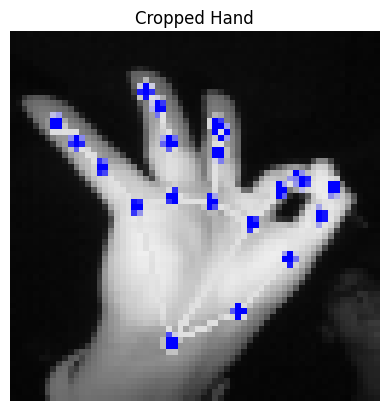

In [8]:
plt.imshow(images[np.random.randint(images.shape[0]), :, :, :])
plt.title('Cropped Hand')
plt.axis('off')
plt.show()

In [9]:
# Преобразование данных в формат PyTorc

images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
images = images/255.0
labels = torch.from_numpy(labels).long()

# Преобразование данных в формат DataLoader
train_dataset = TensorDataset(images, labels)
train_dataloader = DataLoader(train_dataset, batch_size=96, shuffle=True)

In [10]:


# Загрузка предварительно обученной модели VGG-19
vgg19 = models.vgg19(pretrained=True)

num_classes = 10
vgg19.classifier[6] = nn.Linear(4096, num_classes)

# Вывод архитектуры модели
print(vgg19)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
# Определение критерия потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr=0.005, momentum=0.9)

# Обучение модели
num_epochs = 1  # пример, сколько эпох обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

for epoch in range(num_epochs):
    vgg19.train()
    count_batch = 0
    for inputs, labels in train_dataloader:
      count_batch += 1
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = vgg19(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      if count_batch%20==0:
        print(f'process batch {count_batch}/{len(train_dataloader)} epoch: {epoch}')

    # Оценка модели на тестовых данных
    vgg19.eval()
    correct = 0
    total = 0

torch.save(vgg19.state_dict(), path + '/' + 'vgg19_model_mediapipe.pth')

process batch 20/103 epoch: 0
process batch 40/103 epoch: 0
process batch 60/103 epoch: 0
process batch 80/103 epoch: 0
process batch 100/103 epoch: 0


In [12]:
print(loss)

tensor(0.0517, grad_fn=<NllLossBackward0>)


# Тестировка на видеокамере

Эта часть релизованна в отдельном фаиле.